In [1]:
import tqdm
import torch
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt

In [2]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(56274635)

In [3]:
epoches = 50
batch_size = 512
lr = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
mnist_path = 'C:\MyWorks\Git Repository\Remote Repo\cnn\mnist.pkl'
dataset = pickle.load(open(mnist_path,'rb'),encoding='iso-8859-1')

class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, data: tuple):
        self.x_raw, self.y_raw = data
        self.x_raw = torch.from_numpy(self.x_raw).to(device)
        self.y_raw = torch.from_numpy(self.y_raw).to(device)

    def __len__(self):
        return len(self.x_raw)

    def __getitem__(self, idx):
        # return self.x_raw[idx].reshape((1, 28, 28)), torch.eye(10)[self.y_raw[idx]]
        return self.x_raw[idx].reshape((1, 28, 28)), self.y_raw[idx]


train_dataset = MNISTDataset(data=dataset[0])
valid_dataset = MNISTDataset(data=dataset[1])
test_dataset = MNISTDataset(data=dataset[2])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


In [5]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        # (1, 28, 28)
        self.Conv0 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, stride=4)

        # (16, 7, 7)
        self.Flatten0 = torch.nn.Flatten(start_dim=-2, end_dim=-1)


        # (16, 49)
        # permute((0, 2, 1))
        # (49, 16)

        self.Norm0 = torch.nn.BatchNorm1d(num_features=16)

        self.WQ0 = torch.nn.Linear(in_features=16, out_features=32, bias=True)
        self.WK0 = torch.nn.Linear(in_features=16, out_features=32, bias=True)
        self.WV0 = torch.nn.Linear(in_features=16, out_features=32, bias=True)

        # Query(49, 32)
        # Key(49, 32)
        # Value(49, 32)

        self.Attention0 = torch.nn.MultiheadAttention(embed_dim=32, num_heads=8)
        
        self.Norm1 = torch.nn.BatchNorm1d(num_features=32)

        self.Flatten1 = torch.nn.Flatten(start_dim=-2, end_dim=-1)

        self.LeakyReLU0 = torch.nn.LeakyReLU(negative_slope=0.02)

        # (49 * 32 = 784)
        self.Linear0 = torch.nn.Linear(in_features=1568, out_features=256)
        self.ReLU0 = torch.nn.ReLU()

        self.Linear1 = torch.nn.Linear(in_features=256, out_features=10)
        self.Softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.Conv0(x)
        x = self.Flatten0(x)
        # x_res0 = x.clone()
        x = self.Norm0(x)
        x = x.permute((0, 2, 1))
        x_Q0 = self.WQ0(x)
        x_K0 = self.WK0(x)
        x_V0 = self.WV0(x)
        (x, attn_output_weights) = self.Attention0(x_Q0, x_K0, x_V0)
        # x += x_res0.permute((0, 2, 1))
        x = x.permute((0, 2, 1))
        x = self.Norm1(x)
        x = self.Flatten1(x)
        x = self.LeakyReLU0(x)
        x = self.Linear0(x)
        x = self.ReLU0(x)
        x = self.Linear1(x)
        x = self.Softmax(x)
        return x




convnet = ConvNet().to(device)
convnet_optimiser = torch.optim.Adam(convnet.parameters(), lr=lr)
convnet_loss_func = torch.nn.CrossEntropyLoss()

train_loss_list = []
valid_loss_list = []

In [6]:
%matplotlib auto
plt.ion()

for epoch in tqdm.tqdm(range(epoches)):
    for x, y in train_loader:
        convnet_optimiser.zero_grad()
        y_ = convnet(x)
        loss = convnet_loss_func(y_, y)
        loss.backward()
        convnet_optimiser.step()
        train_loss_list.append(loss.mean().item())
        
        plt.subplot(1, 2, 1)
        plt.cla()
        plt.plot(list(range(len(train_loss_list[:-100]), len(train_loss_list))), train_loss_list[-100:], color='black', linewidth=1)
        plt.title('train loss for last 100 cases')
        plt.pause(0.01)

    with torch.no_grad():
        Y, Y_ = torch.tensor([]).to(device), torch.tensor([]).to(device)
        for x, y in valid_loader:
            y_ = convnet(x)
            
            Y = torch.cat((Y, y))
            Y_ = torch.cat((Y_, y_.argmax(dim=1)))

        valid_loss_list.append((Y == Y_).float().mean().item())

    plt.subplot(1, 2, 2)
    plt.cla()
    plt.plot(list(range(len(valid_loss_list[-100:]))), valid_loss_list[-100:], color='red', linewidth=1)
    plt.text(len(valid_loss_list[-100:]), valid_loss_list[-1], str(valid_loss_list[-1]*100))
    plt.title('valid accuracy')
    plt.pause(0.01)

plt.ioff()
plt.close()

  0%|          | 0/50 [00:00<?, ?it/s]

Using matplotlib backend: TkAgg


<ipython-input-5-92e2a3d28013>:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.Softmax(x)
100%|██████████| 50/50 [17:38<00:00, 21.17s/it]


In [7]:
%matplotlib inline

Text(0.5, 1.0, 'train loss')

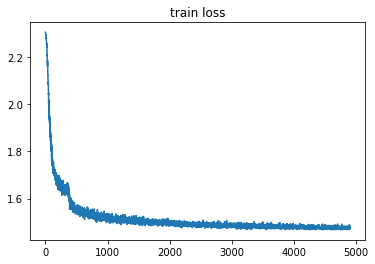

In [8]:
plt.plot(list(range(len(train_loss_list))), train_loss_list)
plt.title('train loss')

Text(0.5, 1.0, 'valid accuracy')

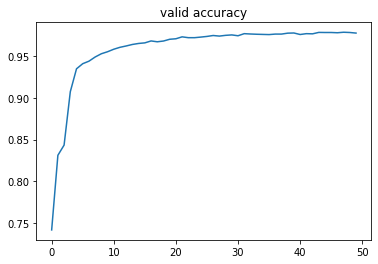

In [9]:
plt.plot(list(range(len(valid_loss_list))), valid_loss_list)
plt.title('valid accuracy')

In [10]:
del train_dataset
del train_loader
del valid_dataset
del valid_loader
torch.cuda.empty_cache()

In [11]:
for x, y in test_loader:
    convnet_optimiser.zero_grad()
    y_ = convnet(x)
    Y = torch.cat((Y, y))
    Y_ = torch.cat((Y_, y_.argmax(dim=1)))
print('test accuracy')
print((Y == Y_).float().mean().item() * 100, '%')
print('GroundTruth:', Y[-10:])
print('Net Outuput:', Y_[-10:])


<ipython-input-5-92e2a3d28013>:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.Softmax(x)


test accuracy
97.72499799728394 %
GroundTruth: tensor([1., 0., 4., 8., 7., 4., 4., 9., 7., 3.], device='cuda:0')
Net Outuput: tensor([1., 0., 4., 8., 7., 4., 4., 9., 7., 3.], device='cuda:0')


In [12]:
with open('attention_log.pkl', 'wb') as f:
    pickle.dump((train_loss_list, valid_loss_list), f)